In [1]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import scipy
import implicit
import bisect
from functools import reduce
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [6]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit_2.pqt'
FEATURES = './features'

In [4]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [10]:
data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pd.DataFrame([(z.name, z.type) for z in data.schema], columns=[['field', 'type']])

,field,type
0,region_name,string
1,city_name,string
2,cpe_manufacturer_name,string
3,cpe_model_name,string
4,url_host,string
5,cpe_type_cd,string
6,cpe_model_os_type,string
7,price,double
8,date,date32[day]
9,part_of_day,string


Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя

In [5]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns=[['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [11]:
% % time
data_agg = data.select(['user_id', 'url_host', 'request_cnt']).group_by(['user_id', 'url_host']).aggregate(
    [('request_cnt', "sum")])

CPU times: user 37.5 s, sys: 33 s, total: 1min 10s
Wall time: 1min 48s


In [12]:
url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users


In [10]:
usr_n_cities = pd.read_csv(f"{FEATURES}/usr_n_cities.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
usr_prt_of_day = pd.read_csv(f"{FEATURES}/usr_prt_of_day.csv").drop(['Unnamed: 0'], axis=1)
usr_request_cnt_sum = pd.read_csv(f"{FEATURES}/usr_request_cnt_sum.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
usr_is_apple = pd.read_csv(f"{FEATURES}/usr_is_apple.csv").drop('Unnamed: 0', axis=1)
usr_url_rf_idf = pd.read_csv(f"{FEATURES}/usr_url_tf_idf.csv").drop('Unnamed: 0', axis=1)
usr_url_count_max_diff = pd.read_csv(f"{FEATURES}/usr_url_count_max_diff.csv").drop('Unnamed: 0', axis=1)

data_frames = [usr_n_cities, usr_prt_of_day, usr_request_cnt_sum, usr_is_apple, usr_url_rf_idf, usr_url_count_max_diff]

df_merged = reduce(lambda left, right: pd.merge(left, right, on=['user_id'],
                                                how='outer'), data_frames)

In [102]:
% % time
values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict))
cols = np.array(data_agg.select(['url_host']).to_pandas()['url_host'].map(url_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors=1000, iterations=50, use_gpu=False,
                                                            calculate_training_loss=False, regularization=0.1)

CPU times: user 11.4 s, sys: 3.11 s, total: 14.5 s
Wall time: 19.1 s


In [103]:
% % time
als.fit(mat)
u_factors = als.model.user_factors
d_factors = als.model.item_factors

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 6h 24min 34s, sys: 53min 6s, total: 7h 17min 41s
Wall time: 1h 57min 37s


In [7]:
u_factors = pd.read_csv("u_factors_factors1000_iter50.csv")
d_factors = pd.read_csv("d_factors_factors1000_iter50.csv")

а## Получим оценку по полу

In [13]:
% % time
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb, how='inner', on=['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 8.34 s, sys: 13 s, total: 21.4 s
Wall time: 30.7 s


1    135331
0    128994
Name: is_male, dtype: int64

In [ ]:
params = {'iterations': 10000,
          'learning_rate': 0.0001,
          'early_stopping_rounds': 10,
          'cat_features': [1003, 1004, 1005, 1006, 1007],
          'verbose': 200,

          }
# depth=7, l2_leaf_reg=6, random_strength=5)

In [48]:
# ['user_id', 'age', 'is_male','request_cnt_sum', 'rating', 'usr_url_count_max_diff', 'is_apple']
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(['user_id', 'age', 'is_male'], axis=1), df['is_male'], test_size=0.25)
clf = CatBoostClassifier(**params)
clf.fit(x_train, y_train, verbose=True, use_best_model=True, eval_set=[(x_test, y_test)])
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1]) - 1:2.3f}')

0:	learn: 0.6931292	test: 0.6931393	best: 0.6931393 (0)	total: 300ms	remaining: 49m 57s
1:	learn: 0.6931254	test: 0.6931317	best: 0.6931317 (1)	total: 582ms	remaining: 48m 30s
2:	learn: 0.6931167	test: 0.6931221	best: 0.6931221 (2)	total: 875ms	remaining: 48m 34s
3:	learn: 0.6931090	test: 0.6931142	best: 0.6931142 (3)	total: 1.15s	remaining: 47m 57s
4:	learn: 0.6931022	test: 0.6931069	best: 0.6931069 (4)	total: 1.42s	remaining: 47m 10s
5:	learn: 0.6930951	test: 0.6930991	best: 0.6930991 (5)	total: 1.7s	remaining: 47m 10s
6:	learn: 0.6930881	test: 0.6930919	best: 0.6930919 (6)	total: 2s	remaining: 47m 35s
7:	learn: 0.6930805	test: 0.6930838	best: 0.6930838 (7)	total: 2.32s	remaining: 48m 17s
8:	learn: 0.6930717	test: 0.6930749	best: 0.6930749 (8)	total: 2.61s	remaining: 48m 16s
9:	learn: 0.6930654	test: 0.6930685	best: 0.6930685 (9)	total: 2.9s	remaining: 48m 20s
10:	learn: 0.6930571	test: 0.6930598	best: 0.6930598 (10)	total: 3.2s	remaining: 48m 24s
11:	learn: 0.6930501	test: 0.6930525

In [14]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [15]:

id_to_submit = reduce(lambda left, right: pd.merge(left, right, on=['user_id'],
                                                how='outer'), [usr_emb,usr_prt_of_day, usr_n_cities])


NameError: name 'usr_emb' is not defined

In [125]:

id_to_submit['is_male'] = clf.predict_proba(id_to_submit)[:, 1]

## Получим оценку по возрасту

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

% matplotlib inline
sns.set_style('darkgrid')

In [127]:
def age_bucket(x):
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

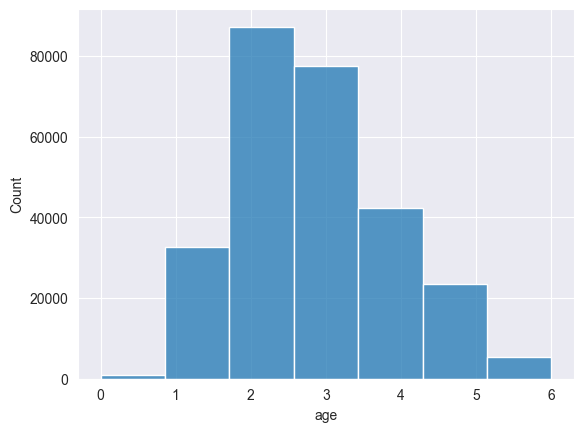

In [128]:
df = usr_targets.merge(usr_emb, how='inner', on=['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins=7)

In [130]:
id_to_submit = reduce(lambda left, right: pd.merge(left, right, on=['user_id'],
                                                how='outer'), [usr_emb,usr_request_cnt_sum, usr_url_count_max_diff])


In [131]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['user_id', 'age', 'is_male'], axis=1), df['age'],
                                                    test_size=0.25, )

clf = CatBoostClassifier(iterations=10000, early_stopping_rounds=10)
clf.fit(x_train, y_train, verbose=False, use_best_model=True, eval_set=[(x_test, y_test)])

print(m.classification_report(y_test, clf.predict(x_test),
                              target_names=['<18', '18-25', '25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       278
       18-25       0.53      0.30      0.39      8243
       25-34       0.48      0.63      0.54     21627
       35-44       0.40      0.53      0.46     19364
       45-54       0.38      0.21      0.27     10622
       55-65       0.41      0.19      0.26      5937
         65+       0.46      0.02      0.03      1419

    accuracy                           0.44     67490
   macro avg       0.38      0.27      0.28     67490
weighted avg       0.44      0.44      0.42     67490



In [132]:
id_to_submit['age'] = clf.predict(id_to_submit.drop('user_id', axis=1))


## Сабмит

In [134]:
id_to_submit = id_to_submit.loc[:, ['user_id', 'is_male', 'age']]

In [167]:
! head $LOCAL_DATA_PATH / submission4.csv

head: ./context_data//submission4.csv: No such file or directory


# Скор на лидерборде

In [151]:
context_scorer(submission, answers)

1.4715992278434493